<a href="https://colab.research.google.com/github/fractal2k/Learning-Deep-Learning/blob/master/torch_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install hiddenlayer

In [ ]:
import numpy as np
# import hiddenlayer as hl
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

In [ ]:
BATCH_SIZE = 128
FIXED_BATCH = 16  # Batch size of the fixed vector used to evaluate generator progression
EPOCHS = 100
Z_LEN = 100  # Length of the latent vector
BETA1 = 0.5  # Beta1 parameter of Adam

In [ ]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='', train=True, transform=transform, download=True)
# You didn't need the testset in the vanilla GAN notebook either you pepega
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [ ]:
# Make a device variable to use the GPU
device = torch.device('cuda:0')

In [ ]:
# torch.randn() returns random numbers from the standard normal distribution
# i.e. with mean 0 and variance 1
def generate_noise_samples_gpu(batch_size):
    return torch.randn(batch_size, Z_LEN, 1, 1, device=device)

def generate_noise_samples_cpu(batch_size):
    return torch.randn(batch_size, Z_LEN, 1, 1)

In [ ]:
def display_img(img, num_gen):
    npimg = img.detach().numpy()
    npimg = npimg / 2 + 0.5
    fig = plt.figure(figsize=(4, 4))

    if(num_gen == 1):
        plt.imshow(npimg, cmap='gray')
        plt.axis('off')
    else:
        for i in range(num_gen):
            plt.subplot(4, 4, i + 1)
            plt.imshow(npimg[i, :, :], cmap='gray')
            plt.axis('off')

    plt.show()


def save_img(img, num_gen, epoch=None):
    npimg = img.detach().numpy()
    npimg = npimg / 2 + 0.5
    fig = plt.figure(figsize=(4,4))

    if(num_gen == 1):
        plt.imshow(npimg, cmap='gray')
        plt.axis('off')
    else:
        for i in range(num_gen):
            plt.subplot(4, 4, i + 1)
            plt.imshow(npimg[i, :, :], cmap='gray')
            plt.axis('off')

    plt.savefig(f'generated_at_epoch_{epoch}.png' if epoch else 'generated_digits.png')

In [ ]:
# The DCGAN paper says that all the weights must be randomly initialized with 
# mean=0 and stddev=0.02
# So, we create a custom function to initialize the weights of the network
def weights_initialization(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Formula of output dimension after deconvolution:
# So = stride(Si - 1) + Sf - 2 * pad
# Si = input size, Sf = kernel size
class GeneratorNetwork(nn.Module):
    def __init__(self):
        super(GeneratorNetwork, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(Z_LEN, 256, 3, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # Output = 3x3

            nn.ConvTranspose2d(256, 128, 3, stride=2, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # Output = 7x7

            nn.ConvTranspose2d(128, 64, 2, stride=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Output = 14x14

            nn.ConvTranspose2d(64, 1, 2, stride=2, bias=False),
            nn.Tanh()
            # Output = 28x28
        )
    
    def forward(self, input):
        return self.main(input)

# Net output of the network will be = (batch_size, channels, width, height)
# torch.squeeze will get rid of the single channel dimension leaving you with:
# (batch_size, width, height)

In [ ]:
# Formula of output dimension after convolution
# O = ((I - K + 2P) / S) + 1
# I = input height/width, K = kernel size, P = padding, S = stride
class DiscriminatorNetwork(nn.Module):
    def __init__(self):
        super(DiscriminatorNetwork, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Output = 14x14

            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # Output = 7x7

            nn.Conv2d(64, 128, 5, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # Output = 3x3

            nn.Conv2d(128, 1, 3, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [ ]:
# Apply the custom weight initialization to our networks
gen = GeneratorNetwork().to(device)
gen.apply(weights_initialization)

dis = DiscriminatorNetwork().to(device)
dis.apply(weights_initialization)

In [ ]:
print(gen)
print(dis)

GeneratorNetwork(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (10): Tanh()
  )
)
DiscriminatorNetwork(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bi

In [ ]:
# Define loss criterion for the network
criterion = nn.BCELoss()

# We create a batch of latent vectors that we will input to the generator at 
# multiple stages in the training to see the progression of our generator
fixed_noise = generate_noise_samples(FIXED_BATCH)

# Define optimizers for both the networks
gen_opt = optim.Adam(gen.parameters(), lr=0.0002, betas=(BETA1, 0.999))
dis_opt = optim.Adam(dis.parameters(), lr=0.0002, betas=(BETA1, 0.999))

In [ ]:
gen_history = hl.History()
dis_history = hl.History()
plot = hl.Canvas()
iters = 0

# Training loop
for epoch in range(EPOCHS):
    # Iterate over each batch in the dataloader
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        ip = inputs.cuda(device)

        # Resetting discriminator gradients
        dis_opt.zero_grad()

        # ======Training the Discriminator======
        # Real inputs
        real_outputs = dis(ip)
        real_labels = torch.ones_like(real_outputs)
        real_loss = criterion(real_outputs, real_labels)
        real_loss.backward()

        # Fake inputs
        gen_inputs = generate_noise_samples(BATCH_SIZE)
        fake_inputs = gen(gen_inputs)
        fake_outputs = dis(fake_inputs)
        fake_labels = torch.zeros_like(fake_outputs)
        fake_loss = criterion(fake_outputs, fake_labels)
        fake_loss.backward()

        # Calculating total loss for discriminator
        total_loss = real_loss + fake_loss
        
        # Update discriminator parameters
        dis_opt.step()


        # Resetting generator gradients
        gen_opt.zero_grad()

        # ======Training the Generator======
        gen_inputs = generate_noise_samples(BATCH_SIZE)
        dis_inputs = gen(gen_inputs)
        dis_outputs = dis(dis_inputs)
        gen_labels = torch.ones_like(dis_outputs)
        gen_loss = criterion(dis_outputs, gen_labels)
        gen_loss.backward()

        # Update generator parameters
        gen_opt.step()


        # Update loss plot after every 10 minibatches
        if i % 10 == 0:
            dis_history.log(i, loss=total_loss)
            gen_history.log(i, loss=gen_loss)
            plot.draw_plot([dis_history['loss'], gen_history['loss']])
        
        # Check out how generator is doing by saving generator's output on
        # fixed noise
        if (iters % 500 == 0) or ((epoch == EPOCHS - 1) and (i == len(trainloader) - 1)):
            with torch.no_grad():
                fake = torch.squeeze(gen(fixed_noise).detach().cpu())
                save_img(fake, FIXED_BATCH, epoch=epoch)
        iters += 1

print('Finished Training')

Buffered data was truncated after reaching the output size limit.

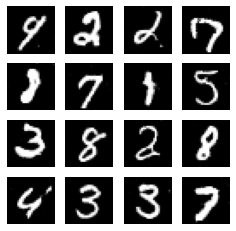

In [ ]:
with torch.no_grad():
    pred_inputs = generate_noise_samples(FIXED_BATCH)
    generated = torch.squeeze(gen(pred_inputs).detach().cpu())
    display_img(generated, FIXED_BATCH)

In [ ]:
torch.save(gen.state_dict(), './dcgan_gen_state_dict.pt')
torch.save(dis.state_dict(), './dcgan_dis_state_dict.pt')

In [ ]:
# Loading the saved model
new_gen = GeneratorNetwork()
new_gen.load_state_dict(torch.load('./dcgan_gen_state_dict.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

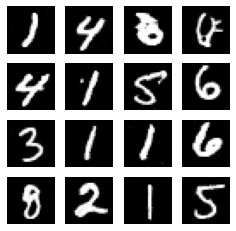

In [ ]:
with torch.no_grad():
    inp = generate_noise_samples_cpu(FIXED_BATCH)
    preds = torch.squeeze(new_gen(inp).detach())
    display_img(preds, FIXED_BATCH)

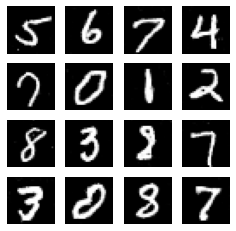

In [ ]:
with torch.no_grad():
    inp = generate_noise_samples_cpu(FIXED_BATCH)
    preds = torch.squeeze(new_gen(inp).detach())
    save_img(preds, FIXED_BATCH)

In [ ]:
# Visualizing models
gen_model = GeneratorNetwork()
hl_gen = hl.build_graph(gen_model, torch.zeros([1, 100, 1, 1]))
hl_gen.theme = hl.graph.THEMES['blue'].copy()
hl_gen.save('generator_model_diagram', format='png')

In [ ]:
dis_model = DiscriminatorNetwork()
hl_dis = hl.build_graph(dis_model, torch.zeros([1, 1, 28, 28]))
hl_dis.theme = hl.graph.THEMES['blue'].copy()
hl_dis.save('discriminator_model_diagram', format='png')